# Experiments with MNIST Dataset and Original MoE

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:1


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best performance
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_stochastic_model import moe_stochastic_model
from moe_models.moe_top_k_model import moe_top_k_model
from moe_models.moe_models_base import default_optimizer
from helper.moe_models import cross_entropy_loss, stochastic_loss
from helper.visualise_results import *

device cuda:0


In [10]:
from itertools import product

w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
sample_sim_weights = list(product(w_sample_sim_same_range,w_sample_sim_diff_range))

print(sample_sim_weights, len(sample_sim_weights))
index = 3
w_sample_sim_same = sample_sim_weights[index][0]
w_sample_sim_diff = sample_sim_weights[index][1]
print(w_sample_sim_same, w_sample_sim_diff)

[(0.001, 1e-07), (0.001, 1e-06), (0.001, 1e-05), (0.001, 0.0001), (0.001, 0.001), (0.001, 0.01), (0.001, 0.1)] 7
0.001 0.0001


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models, figures and results will be stored. You can change this as you see fit.
fig_path = '../figures/mnist'
model_path = '../models/mnist'
results_path = '../results/mnist'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) #mean and standard deviation computed from the dataset

In [8]:
# Complete train and test data
trainsize = 60000
testsize = 10000

In [9]:
batch_size = 512

In [10]:
# Load data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


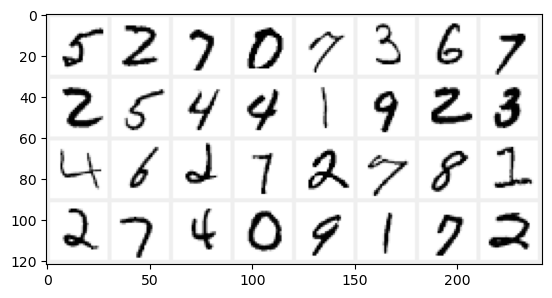

In [11]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        self.mp = nn.MaxPool2d(2,2)
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv1
        t = self.mp(F.relu(self.conv1(t)))
        
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = F.relu(self.fc1(t))

        # fc2
        t = F.relu(self.fc2(t))

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [36]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.mp = nn.MaxPool2d(2,2)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.MaxPool2d) or isinstance(module, gate_layers):
            return
        module.weight.data.zero_()
        if module.bias is not None:
            module.bias.data.zero_()


    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.mp(F.relu(self.conv1(t)))
        
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = F.relu(self.fc1(t))

        # fc2
        t = F.relu(self.fc2(t))

        # output expert log loss
        t = self.out(t)
        
        output = F.softmax(t, dim=1)

        return output


In [37]:
gate = gate_layers(10)

In [38]:
for param in gate.parameters():
    print(param)

Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [36]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers_top_k(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers_top_k, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.mp = nn.MaxPool2d(2,2)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.mp(F.relu(self.conv1(t)))
        
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = F.relu(self.fc1(t))

        # fc2
        t = F.relu(self.fc2(t))

        # output expert log loss
        t = self.out(t)
        
        output = t/T

        return output

In [37]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [38]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation. The single model has the same
# architecture as an expert
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

## Initialize configurations and helper functions

In [39]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train original model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [46]:
def train_original_model(model_1,  model_name, k=0, trainloader=trainloader, testloader=testloader, runs=1,
                         temps=[[1.0]*20], w_importance_range=[0.0], 
                         w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20):
    
    moe_model_types = {'moe_expectation_model':(moe_expectation_model,cross_entropy_loss().to(device)),
                       'moe_stochastic_model':(moe_stochastic_model, stochastic_loss(cross_entropy_loss).to(device)),
                       'moe_top_1_model':(moe_top_k_model, stochastic_loss(cross_entropy_loss).to(device)),
                       'moe_top_k_model':(moe_top_k_model, cross_entropy_loss().to(device))                 
                      }


    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, 
                                                                                      w_sample_sim_same_range,  
                                                                                      w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
 
        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {model_name:{'model':moe_model_types[model_name][0],'loss':moe_model_types[model_name][1],
                                               'experts':{}},}

            for key, val in models.items():

                expert_models = experts(total_experts, num_classes)

                gate_model = gate_layers(total_experts)

                if k > 0:
                    moe_model = val['model'](k, total_experts, num_classes,
                                             experts=expert_models, gate=gate_model, device=device).to(device)
                else:
                    moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model, device=device).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                optimizer = default_optimizer(optimizer_moe=optimizer_moe)
                
                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer = optimizer, T = T, 
                                       w_importance=w_importance, w_sample_sim_same = w_sample_sim_same, 
                                       w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            if  os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []


### Function to train the single model

In [41]:
def train_single_model(model_name, trainloader, testloader, num_classes, num_epochs, runs):
    
    loss_criterion = cross_entropy_loss()
    
    n_runs = {'models':[], 'history':[]}
    
    for run in range(1, runs+1):
        
        print('Run', run)
        
        model = single_model(num_classes).to(device)
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=False)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                optimizer.zero_grad()
                loss = loss_criterion(outputs, None, None, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = model(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            test_running_accuracy = 0.0
            test_num_batches = 0
            
            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)
                test_outputs = model(test_inputs)              
                test_running_accuracy += accuracy(test_outputs, test_labels)
                test_num_batches += 1
                
            loss = (running_loss/num_batches)
            train_accuracy = (train_running_accuracy/num_batches)
            test_accuracy = (test_running_accuracy/test_num_batches)
            
            history['loss'].append(loss)
            history['accuracy'].append(train_accuracy.item())
            history['val_accuracy'].append(test_accuracy.item())
            
            print('epoch %d' % epoch,
                  'training loss %.2f' % loss,
                   ', training accuracy %.2f' % train_accuracy,
                   ', test accuracy %.2f' % test_accuracy
                   )
        
        # Save all the trained models
        plot_file = generate_plot_file(model_name, specific=str(num_classes)+'_models.pt')
        if  os.path.exists(os.path.join(model_path, plot_file)):
            n_runs = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        n_runs['models'].append(model)
        n_runs['history'].append(history)        
        torch.save(n_runs, open(os.path.join(model_path, plot_file),'wb'))
        
        n_runs = {'models':[], 'history':[]}

## Experiments

### Experiment 1: Original MoE model trained without gate regularization

In [42]:
total_experts = 10

In [43]:
num_epochs = 20

In [44]:
runs = 1

In [47]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_top_1_test'
train_original_model(model_1, 'moe_top_1_model', 1, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 0.89 , training accuracy 0.42 , test accuracy 0.69
epoch 1 training loss 0.36 , training accuracy 0.75 , test accuracy 0.80
epoch 2 training loss 0.28 , training accuracy 0.82 , test accuracy 0.85
epoch 3 training loss 0.24 , training accuracy 0.86 , test accuracy 0.87
epoch 4 training loss 0.21 , training accuracy 0.87 , test accuracy 0.87
epoch 5 training loss 0.20 , training accuracy 0.88 , test accuracy 0.88
epoch 6 training loss 0.19 , training accuracy 0.88 , test accuracy 0.89
epoch 7 training loss 0.19 , training accuracy 0.89 , test accuracy 0.89
epoch 8 training loss 0.18 , training accuracy 0.89 , test accuracy 0.89
epoch 9 training loss 0.18 , training accuracy 0.89 , test accuracy 0.89
epoch 10 training loss 0.17 , training accuracy 0.89 , test accuracy 0.89
epoch 11 training loss 0.17 , training accuracy 0.90 , test accuracy 0.90
epoch 12 training loss 0.17 , training accuracy 0.90 ,

In [48]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_top_1_test'
train_original_model(model_1, 'moe_top_k_model', 1, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.84 , training accuracy 0.34 , test accuracy 0.66
epoch 1 training loss 0.71 , training accuracy 0.78 , test accuracy 0.84
epoch 2 training loss 0.51 , training accuracy 0.84 , test accuracy 0.86
epoch 3 training loss 0.46 , training accuracy 0.86 , test accuracy 0.87
epoch 4 training loss 0.43 , training accuracy 0.87 , test accuracy 0.88
epoch 5 training loss 0.40 , training accuracy 0.88 , test accuracy 0.88
epoch 6 training loss 0.39 , training accuracy 0.88 , test accuracy 0.88
epoch 7 training loss 0.38 , training accuracy 0.89 , test accuracy 0.89
epoch 8 training loss 0.37 , training accuracy 0.89 , test accuracy 0.89
epoch 9 training loss 0.36 , training accuracy 0.89 , test accuracy 0.89
epoch 10 training loss 0.35 , training accuracy 0.89 , test accuracy 0.89
epoch 11 training loss 0.35 , training accuracy 0.89 , test accuracy 0.89
epoch 12 training loss 0.34 , training accuracy 0.90 ,

In [25]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_top_5_test'
train_original_model(model_1, 'moe_top_k_model', 5, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 0.81 , training accuracy 0.47 , test accuracy 0.73
epoch 1 training loss 0.35 , training accuracy 0.78 , test accuracy 0.84
epoch 2 training loss 0.22 , training accuracy 0.88 , test accuracy 0.92


KeyboardInterrupt: 

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_stochastic'
train_original_model(model_1, 'moe_stochastic_model', trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_without_reg_top_2'
train_original_model(model_1, 'moe_top_2_model', 2, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

In [ ]:
# Model with gate and expert parameters initialized to default values
for k in range(3,num_classes):
    model_1 = 'mnist_without_reg_top_'+str(k)
    train_original_model(model_1, 'moe_top_'+str(k)+'_model', k, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 2: Original MoE model trained with $L_{importance}$ regularization

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_reg_hidden_32_test'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = [0.2,1.0]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

In [ ]:
runs = 1

In [ ]:
train_original_model(model_2, trainloader, testloader, runs, w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

### Experiment 3: Original MoE model trained with sample similarity regularization, $L_s$

In [ ]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_with_reg_hidden_32'

In [ ]:
total_experts = 15

In [ ]:
num_epochs = 20

In [ ]:
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

In [ ]:
runs = 1

In [ ]:
train_original_model(model_3, trainloader, testloader, runs, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 4: Training the single model

In [ ]:
model_4 = 'mnist_single_model_hidden_32'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, trainloader, testloader, num_classes, num_epochs, runs)

## Results

### Collect the train error, test error for the trained single models and store in the '../results/mnist_results.csv' file.

In [ ]:
import csv

m = 'mnist_single_model_hidden_32'
plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')

# loading model from pre_trained_model_path. Change this to model_path to use models you train
models = torch.load(open(os.path.join(pre_trained_model_path,'mnist', plot_file),'rb'), map_location=device)

filename = os.path.join(results_path, 'mnist_results.csv')

if os.path.exists(filename):
    p = 'a'
else:
    p = 'w'
        
header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'expert usage']
    
with open(filename, p) as f:
    writer = csv.writer(f)        

    if p == 'w':            
        writer.writerow(header)
    for i, model in enumerate(models['models']):
        data = ['']*5
        data[0] = m+'_'+str(i)
        running_test_accuracy = 0.0
        num_batches = 0
        train_error = 1-models['history'][i]['accuracy'][-1]
        data[1] = train_error
        for test_inputs, test_labels in testloader:
            test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
            outputs = model(test_inputs)
            running_test_accuracy += accuracy(outputs, test_labels)
            num_batches += 1
        test_error = 1-(running_test_accuracy/num_batches)
        data[2] = test_error.item()
        
        writer.writerow(data)


In [ ]:
import sys
sys.path.append('../src/mnist')

In [ ]:
pre_trained_model_path=model_path

In [ ]:
m='mnist_without_reg_top_10'
total_experts = 10
classes = range(num_classes)
num_epochs = 20
temps=[[1]*num_epochs]
test_loader = testloader

w_importance_range = [0.0]

plot_expert_usage(m, test_loader, temps=temps,
                  w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=pre_trained_model_path, dataset='mnist', device=device)